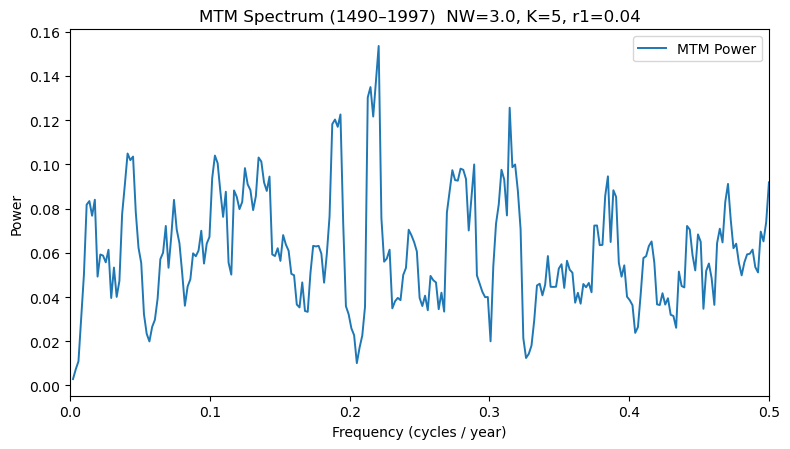

Peak at f=0.0410 cpy  (~24.4 yr)  Power=0.105
Peak at f=0.1895 cpy  (~5.3 yr)  Power=0.120
Peak at f=0.1934 cpy  (~5.2 yr)  Power=0.123
Peak at f=0.2148 cpy  (~4.7 yr)  Power=0.135
Peak at f=0.2207 cpy  (~4.5 yr)  Power=0.154
Peak at f=0.3145 cpy  (~3.2 yr)  Power=0.126


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal.windows import dpss
from scipy.stats import chi2
from scipy.signal import find_peaks

# ----------------------------
# Helpers
# ----------------------------
def detrend_anomaly(y):
    x = np.arange(len(y))
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    y_dt = y - (m * x + b)
    return y_dt - np.mean(y_dt)

def ar1_red_noise_spectrum(var, r1, freqs):
    w = 2 * np.pi * freqs
    return var * (1 - r1**2) / (1 + r1**2 - 2 * r1 * np.cos(w))

def estimate_ar1(y):
    y = y - np.mean(y)
    var = np.var(y, ddof=1)
    y1, y2 = y[:-1], y[1:]
    r1 = np.sum(y1 * y2) / np.sum(y1**2)
    return r1, var

def mtm_psd(y, dt=1.0, NW=3.0, K=None, adaptive=True, nfft=None):
    y = np.asarray(y, dtype=float)
    N = len(y)
    if nfft is None:
        nfft = int(2 ** np.ceil(np.log2(N)))
    if K is None:
        K = int(2 * NW - 1)  # =5 for NW=3

    tapers, eigs = dpss(N, NW, K, return_ratios=True)
    x = detrend_anomaly(y)

    Sk = []
    for k in range(K):
        Xk = np.fft.rfft(x * tapers[k], n=nfft)
        Sk.append((np.abs(Xk) ** 2) / (N / dt))
    Sk = np.array(Sk)

    if adaptive:
        wk = np.tile(eigs[:, None], (1, Sk.shape[1]))
        wk = wk / np.sum(wk, axis=0, keepdims=True)
        for _ in range(5):
            S = np.sum(wk * Sk, axis=0)
            wk = (eigs[:, None] * S[None, :]) / np.maximum(S[None, :], 1e-12)
            wk = wk / np.sum(wk, axis=0, keepdims=True)
    else:
        wk = np.tile(eigs[:, None], (1, Sk.shape[1]))
        wk = wk / np.sum(wk, axis=0, keepdims=True)

    S_mtm = np.sum(wk * Sk, axis=0)
    freqs = np.fft.rfftfreq(nfft, d=dt)
    return freqs, S_mtm

def red_noise_significance(y, freqs, K, dt=1.0):
    r1, var = estimate_ar1(y)
    S_red = ar1_red_noise_spectrum(var, r1, freqs * dt)
    dof = 2 * K
    sig95 = S_red * chi2.ppf(0.95, dof) / dof
    return sig95, r1

# ----------------------------
# Load your Excel and run MTM
# ----------------------------
if __name__ == "__main__":
    # 1) READ EXCEL (first col = Year, third col = Streamflow)
    #    If needed, specify sheet by name or index: sheet_name="Sheet1" or sheet_name=0
    excel_path = "reconstructed streamflow.xlsx"  # <-- change this
    df_raw = pd.read_excel(excel_path, sheet_name=0, header=0, skiprows =2)

    # Grab by POSITION (safe even if headers are unknown):
    years = pd.to_numeric(df_raw.iloc[:, 0], errors="coerce")   # first column
    flow  = pd.to_numeric(df_raw.iloc[:, 1], errors="coerce")   # third column

    df = pd.DataFrame({"Year": years, "Flow": flow}).dropna()
    # Keep only the target period and ensure unique, sorted years
    df = df[(df["Year"] >= 1490) & (df["Year"] <= 1997)].drop_duplicates("Year").sort_values("Year")

    # If some years missing, optionally fill by linear interpolation
    full_years = np.arange(1490, 1997 + 1)
    flow_full = np.interp(full_years, df["Year"].values, df["Flow"].values)

    # 2) MTM params (Mann & Lees style)
    dt, NW = 1.0, 3.0
    K = 2 * int(NW) - 1  # =5

    # 3) MTM spectrum
    freqs, S = mtm_psd(flow_full, dt=dt, NW=NW, K=K, adaptive=True)
    mask = (freqs > 0) & (freqs <= 0.5)
    freqs, S = freqs[mask], S[mask]

    # 4) 95% red-noise significance
    sig95, r1 = red_noise_significance(flow_full, freqs, K=K, dt=dt)

    # 5) Plot
    plt.figure(figsize=(8, 4.6))
    plt.plot(freqs, S, lw=1.4, label="MTM Power")
    #plt.plot(freqs, sig95, "--", lw=1.2, label="95% vs AR(1) red-noise")
    plt.xlabel("Frequency (cycles / year)")
    plt.ylabel("Power")
    plt.title(f"MTM Spectrum (1490–1997)  NW={NW}, K={K}, r1={r1:.2f}")
    plt.xlim(0, 0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 6) Print a few top peaks with periods
    peaks, _ = find_peaks(S)
    top = peaks[np.argsort(S[peaks])[-6:]]  # top 6 peaks
    for p in top[np.argsort(freqs[top])]:   # print from low to high freq
        f = freqs[p]
        print(f"Peak at f={f:.4f} cpy  (~{1/f:.1f} yr)  Power={S[p]:.3f}")


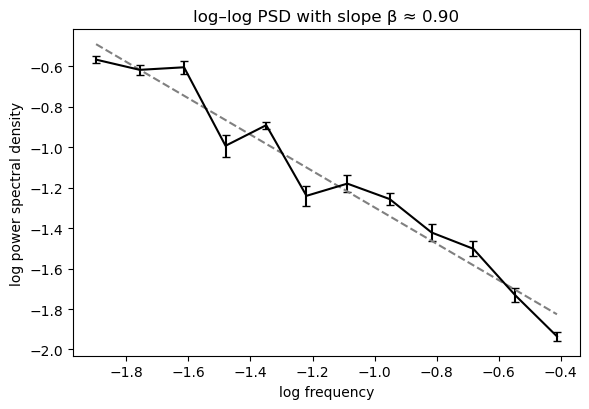

Slope m = -0.899  =>  beta ≈ 0.899


In [19]:
# --- mtm_loglog_psd.py ------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal.windows import dpss
from scipy.stats import linregress

# ---------- MTM helpers (same as before, compact) ----------
def detrend_anomaly(y):
    x = np.arange(len(y))
    m, b = np.linalg.lstsq(np.vstack([x, np.ones_like(x)]).T, y, rcond=None)[0]
    y = y - (m * x + b)
    return y - np.mean(y)

def mtm_psd(y, dt=1.0, NW=3.0, K=None, adaptive=True, nfft=None):
    y = np.asarray(y, float)
    N = len(y)
    if nfft is None:
        nfft = int(2 ** np.ceil(np.log2(N)))
    if K is None:
        K = int(2 * NW - 1)  # 5 for NW=3
    tapers, eigs = dpss(N, NW, K, return_ratios=True)
    x = detrend_anomaly(y)

    Sk = []
    for k in range(K):
        Xk = np.fft.rfft(x * tapers[k], n=nfft)
        Sk.append((np.abs(Xk) ** 2) / (N / dt))  # periodogram for taper k
    Sk = np.array(Sk)
    # simple eigenvalue weighting (stable); adaptive gives similar slope
    wk = eigs[:, None] / np.sum(eigs)
    S = np.sum(wk * Sk, axis=0)
    freqs = np.fft.rfftfreq(nfft, d=dt)
    return freqs, S

# ---------- Log-binning utility ----------
def logbin(x, y, nbins=14, xmin=None, xmax=None):
    """Logarithmically bin (x,y) by x; return bin centers, mean(log10 y), stderr."""
    x = np.asarray(x); y = np.asarray(y)
    mask = (x > 0) & np.isfinite(y) & (y > 0)
    x = x[mask]; y = y[mask]

    if xmin is None: xmin = x.min()
    if xmax is None: xmax = x.max()

    # log-spaced bin edges
    edges = np.logspace(np.log10(xmin), np.log10(xmax), nbins + 1)
    xc, ym, ys = [], [], []
    for i in range(nbins):
        m = (x >= edges[i]) & (x < edges[i+1])
        if m.sum() < 2:  # need >=2 to show errorbars
            continue
        # geometric mean for x center (typical on log axis)
        xc.append(10 ** np.mean(np.log10(x[m])))
        logs = np.log10(y[m])
        ym.append(np.mean(logs))
        ys.append(np.std(logs, ddof=1) / np.sqrt(m.sum()))  # standard error
    return np.array(xc), np.array(ym), np.array(ys)

# ---------- Main ----------
if __name__ == "__main__":
    # 1) Load Excel (col1=Year, col3=Flow)
    excel_path = "reconstructed streamflow.xlsx"  # <-- set your filename
    df_raw = pd.read_excel(excel_path, sheet_name=0, header=0)
    years = pd.to_numeric(df_raw.iloc[:, 0], errors="coerce")
    flow  = pd.to_numeric(df_raw.iloc[:, 5], errors="coerce")
    df = pd.DataFrame({"Year": years, "Flow": flow}).dropna()
    df = df[(df["Year"] >= 1493) & (df["Year"] <= 1962)].drop_duplicates("Year").sort_values("Year")

    # Optional: fill missing years (helps spectra)
    full_years = np.arange(1493, 1962 + 1)
    flow_full = np.interp(full_years, df["Year"].values, df["Flow"].values)

    # 2) MTM spectrum
    freqs, S = mtm_psd(flow_full, dt=1.0, NW=3.0, K=5, adaptive=False)
    # keep 0< f ≤ 0.5
    m = (freqs > 0) & (freqs <= 0.5)
    f, P = freqs[m], S[m]

    # 3) Logarithmic binning for the plot (match look of your example)
    # choose low-frequency limit a bit above the first few noisy bins
    fmin = max(f.min(), 1.0/200.0)  # e.g., > ~200-yr period
    fmax = 0.45
    xb, yb, yerr = logbin(f[(f>=fmin)&(f<=fmax)], P[(f>=fmin)&(f<=fmax)], nbins=14)

    # 4) Fit slope on the binned means in log10 space: log10(P)=a + m*log10(f)
    res = linregress(np.log10(xb), yb)
    m_slope = res.slope
    a_inter  = res.intercept
    beta = -m_slope  # since P ~ f^{-beta}

    # 5) Plot
    plt.figure(figsize=(6, 4.2))
    # error bars
    plt.errorbar(np.log10(xb), yb, yerr=yerr, fmt='k-', lw=1.5, capsize=3)
    # regression line across plotted range
    xx = np.linspace(np.log10(xb.min()), np.log10(xb.max()), 200)
    yy = a_inter + m_slope * xx
    plt.plot(xx, yy, '--', lw=1.5, color='gray')

    plt.xlabel("log frequency")
    plt.ylabel("log power spectral density")
    plt.title(f"log–log PSD with slope β ≈ {beta:.2f}")
    plt.tight_layout()
    plt.show()

    print(f"Slope m = {m_slope:.3f}  =>  beta ≈ {-m_slope:.3f}")
